File Name: assignment_03b.ipynb

Description: This program performs feature extraction using a pre-trained VGG16 model, freezing all convolutional layers and retraining only the classifier head for two epochs on the exotic animal dataset, and includes a function to predict and display a single image with its class and probability.

Note: Models not included due to GitHub size constraints.

Record of Revisions (Date | Author | Change):  
09/02/2025 | Rhys DeLoach | Initial creation

In [1]:
# Import Libraries
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader

from typing import List, Tuple
from PIL import Image
from timeit import default_timer as timer 
import matplotlib.pyplot as plt

In [2]:
# Load Model
weights = models.VGG16_Weights.DEFAULT # Model Weights
modelTransform = weights.transforms() # Model Transforms

In [3]:
# Loading Data
trainData = datasets.ImageFolder('data/train/', transform = modelTransform) # Initialize train data
valData = datasets.ImageFolder('data/valid/', transform = modelTransform) # Initialize validation data

# Set up Dataloaders
trainLoader = DataLoader(trainData, batch_size = 32, shuffle = True)
testLoader = DataLoader(valData, batch_size = 32)

classNames = trainData.classes # Pull Class Names
outputShape = len(classNames) # Set Output Shape to Number of Classes

device = 'mps' if torch.mps.is_available() else 'cpu' # Use MPS gpu else cpu
torch.manual_seed(42) # Set Seed Reproducibility

lossFunc = nn.CrossEntropyLoss() # Loss Function

In [4]:
# Feature Extraction
model = models.vgg16(weights = weights).to(device) # Initialize Model

for param in model.features.parameters(): # Freeze Feature Layers
    param.requires_grad = False

# Rebuild Classifier Head
model.classifier = nn.Sequential(
    nn.Linear(in_features=25088, out_features=4096, bias=True),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(in_features=4096, out_features=4096, bias=True),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(in_features=4096, out_features=outputShape, bias=True)).to(device) 

optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # Set Optimizer

# Train Model
start_time = timer() # Start the timer

epochs = 2 # Set number of epochs

# Create empty results dictionary
results = {"train_loss": [],
           "train_acc": [],
           "test_loss": [],
           "test_acc": []
}

model.train() # Put model in train mode

# Train for n epochs
for epoch in range(epochs):
    train_loss, train_acc = 0, 0 # Setup train loss and train accuracy values

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(trainLoader):
        X, y = X.to(device), y.to(device) # Send data to target device
    
        y_pred = model(X) # Forward Pass
    
        loss = lossFunc(y_pred, y) # Calculate and accumulate loss

        train_loss += loss.item() 
        
        optimizer.zero_grad() # Optimizer zero grad
    
        loss.backward() # Loss backward
    
        optimizer.step() # Optimizer step
    
        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += ((y_pred_class == y).sum().item()/len(y_pred))

       # Test loop
        model.eval() # Put model in eval mode
    
        # Setup test loss and test accuracy values
        test_loss, test_acc = 0, 0
    
        # Turn on inference context manager
        with torch.inference_mode():
            # Loop through DataLoader batches
            for batch, (X, y) in enumerate(testLoader):
                X, y = X.to(device), y.to(device) # Send data to target device
    
                test_pred_logits = model(X) # Forward Pass
    
                loss = lossFunc(test_pred_logits, y) # Calculate and accumulate loss
                test_loss += loss.item()
    
                # Calculate and accumulate accuracy
                test_pred_labels = test_pred_logits.argmax(dim=1)
                test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))
    
    # Metrics to get average loss and accuracy per batch 
    train_loss = train_loss / len(trainLoader)
    train_acc = train_acc / len(trainLoader)
    test_loss = test_loss / len(testLoader)
    test_acc = test_acc / len(testLoader)
    
    print(f"Epoch:{epoch} Average Train Loss: {train_loss:.3f} Average Train acc: {train_acc:.2f} Average Test Loss: {test_loss:.3f} Average Test Acc: {test_acc:.2f}")

    # Update results dictionary - this will be used later to plot the loss curve
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

# End the timer and print out how long it took
end_time = timer()
print(f"\nTotal training time: {end_time-start_time:.3f} seconds")

torch.save(model.state_dict(), "output/modelFeatureExtraction.pth")

Epoch:0 Average Train Loss: 6.236 Average Train acc: 0.47 Average Test Loss: 0.496 Average Test Acc: 0.82
Epoch:1 Average Train Loss: 0.234 Average Train acc: 0.93 Average Test Loss: 0.472 Average Test Acc: 0.87

Total training time: 37.350 seconds


In [5]:
def pred_and_plot_image(model_path: str,
                        image_path: str, 
                        class_names: List[str],
                        image_size: Tuple[int, int] = (224, 224),
                        transform: torchvision.transforms = None,
                        device: torch.device = torch.device('mps' if torch.mps.is_available() else 'cpu')
                       ):
    
    # Open image
    img = Image.open(image_path)

    # Create transformation for image (if one doesn't exist)
    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
        ])
        
    state_dict = torch.load(model_path, map_location=device) # Load model weights
    model.load_state_dict(state_dict) # Apply weights to model
    model.to(device) # Make sure the model is on the target device

    model.eval() # Turn on model evaluation mode and inference mode
    with torch.inference_mode():
      transformed_image = image_transform(img).unsqueeze(dim=0) # Transform and add an extra dimension to image (model requires samples in [batch_size, color_channels, height, width])

      target_image_pred = model(transformed_image.to(device)) # Make a prediction on image with an extra dimension and send it to the target device

    target_image_pred_probs = torch.softmax(target_image_pred, dim=1) # Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)

    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1) # Convert prediction probabilities -> prediction labels

    # Plot image with predicted label and probability 
    plt.figure()
    plt.imshow(img)
    plt.title(f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}")
    plt.axis(False)

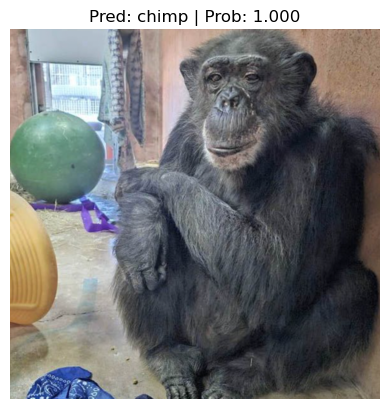

In [6]:
pred_and_plot_image(model_path = "output/modelFeatureExtraction.pth",
                    image_path='data/test/Chimp Test.png',
                    class_names=classNames,
                   transform = modelTransform)